<a href="https://colab.research.google.com/github/SimonR99/QSVM-genetics/blob/main/qkmean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit==0.36.2
!pip install chart_studio
!pip install pylatexenc==2.10

# Quantum variation of a K-mean algorithm

## Introduction

## Classic K-means

The k-means algorithm involves taking k random points and dividing a data group into categories. K-means is an unsupervised machine learning algorithm. This means that it will categorize the different values by itself. It uses "centroids" which move with each iteration based on the values that make up the list of values close to the point.

## Quantum K-means

The quantum K-means algorithm primarily uses the swap test to measure the distance between other points during the training phase. The following code is a function that creates an oracle that performs a swap test with all the values in the list. To avoid having to encode different parts each time, we will use qRAM, which is the quantum version of regular RAM.

## QRAM

QRAM allows for easier access to information without having to change the circuit with each access. There are several types of QRAM, and each has its advantages. One of the most commonly used QRAMs is the "bucket brigade." We experimented with it and recreated the circuit from [quantumcomputinguk](https://quantumcomputinguk.org/tutorials/implementing-qram-in-qiskit-with-code), but this approach turned out to be a dead-end since we need the data only once per "shot" in the circuit.

## Creation of the quantum oracle.

To create our version of the QRAM that allows us to superpose all the centroids, we implemented a quantum oracle. To do this, we compute the binary expansion of the index of all the centroids, which we then translate into a "pattern" of Pauli-X gates. This allows us to create a circuit that assigns a unique index to each centroid. It should be noted that we must have exactly 2 raised to the power of N centroids for the oracle to work correctly. To address this issue, we add |0> states for each unused index, and we ignore these unused indexes when compiling the results.

# Algorithm

## Importing the Libraries

In [2]:
from qiskit import Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.data_preparation import StatePreparation
from qiskit.circuit.library import U3Gate
import qiskit


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


from colorsys import rgb_to_hls, hls_to_rgb


import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
from plotly.graph_objs import *

## Paramètres modifiable

In [3]:
# Heatmap size
heatmap_size = 10

# Percentage of angle space not used per qubit.
qubit_void = 0.3


# Point to test
y_p = 1
x_p = 1

## Data exploration

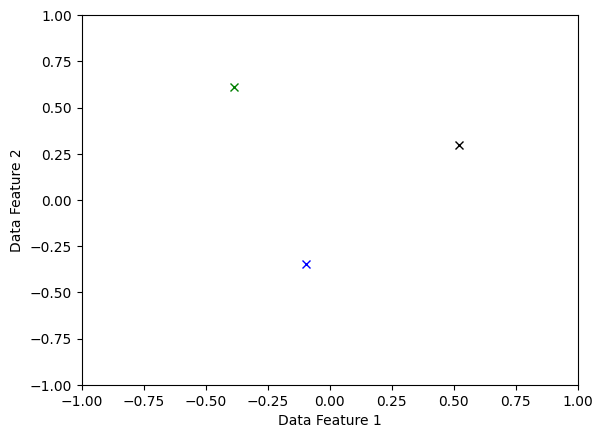

In [4]:
fig, ax = plt.subplots()
ax.set(xlabel='Data Feature 1', ylabel='Data Feature 2')

data = pd.read_csv('kmeansdata.csv', usecols=['Feature 1', 'Feature 2', 'Class'])

isGreen = data['Class'] == 'Green'
isBlue = data['Class'] == 'Blue'
isBlack = data['Class'] == 'Black'

greenData = data[isGreen].drop(['Class'], axis=1)
blueData = data[isBlue].drop(['Class'], axis=1)
blackData = data[isBlack].drop(['Class'], axis=1)

xgc = greenData.iloc[:,0].sum()/greenData.iloc[:,0].count()
xbc = blueData.iloc[:,0].sum()/blueData.iloc[:,0].count()
xkc = blackData.iloc[:,0].sum()/blackData.iloc[:,0].count()

ygc = greenData.iloc[:,1].sum()/greenData.iloc[:,1].count()
ybc = blueData.iloc[:,1].sum()/blueData.iloc[:,1].count()
ykc = blackData.iloc[:,1].sum()/blackData.iloc[:,1].count()

# Plotting the centroids
plt.plot(xgc, ygc, 'gx')
plt.plot(xbc, ybc, 'bx')
plt.plot(xkc, ykc, 'kx')


# Setting the axis ranges
plt.axis([-1, 1, -1, 1])

plt.show()

In [5]:
radius = 1

rad_x_p = radius * np.cos(y_p) * np.cos(x_p)
rad_y_p = radius * np.cos(y_p) * np.sin(x_p)
rad_z_p = radius * np.sin(y_p)

rad_xgc = radius * np.cos(ygc) * np.cos(xgc)
rad_ygc = radius * np.cos(ygc) * np.sin(xgc)
rad_zgc = radius * np.sin(ygc)

rad_xbc = radius * np.cos(ybc) * np.cos(xbc)
rad_ybc = radius * np.cos(ybc) * np.sin(xbc)
rad_zbc = radius * np.sin(ybc)

rad_xkc = radius * np.cos(ykc) * np.cos(xkc)
rad_ykc = radius * np.cos(ykc) * np.sin(xkc)
rad_zkc = radius * np.sin(ykc)

data = [
    [rad_x_p, rad_y_p, rad_z_p, 'red'],
    [rad_xgc, rad_ygc, rad_zgc, 'green'],
    [rad_xbc, rad_ybc, rad_zbc, 'blue'],
    [rad_xkc, rad_ykc, rad_zkc, 'black']
    ]
dataset = pd.DataFrame(data, columns=['X', 'Y','Z', 'Color'])
print(dataset)

          X         Y         Z  Color
0  0.291927  0.454649  0.841471    red
1  0.759215 -0.309562  0.572507  green
2  0.937028 -0.087774 -0.338046   blue
3  0.828624  0.477966  0.291429  black


In [6]:
def get_sphere_projection_figure(dataset):
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)
    sphere_data = [
    Surface(
        x=x,
        y=y,
        z=z,
        surfacecolor=x**2 + y**2 + z**2,
        colorscale='Blackbody',
        showscale=False
    ),
    ]
    sphere_fig = go.Figure(data=sphere_data)
    points_fig = px.scatter_3d(dataset, x='X', y='Y', z='Z',
                color='Color', color_discrete_sequence=["red", "lime", "cyan", "black"])
    return go.Figure(data = sphere_fig.data + points_fig.data)

In [7]:
get_sphere_projection_figure(dataset).show()

## Creation of the Quantum Circuit

### Creation of the Quantum Oracle

In [8]:
import math

def first_power_of_two_above_or_equal(num):
    exponent = 0
    power = 1
    while power < num :
        power *= 2
        exponent += 1

    return (exponent, power)

def get_binary_expansion(num):
    if num == 0:
        return [0]

    digits = []
    remainder = num

    while remainder > 0:
        digit = remainder % 2
        remainder = remainder // 2
        digits.insert(0, digit)

    return digits;

def create_oracle(angle_theta_list, angle_phi_list, quantum_circuit, control_qubit, train_qubit, comp_basis_reg):
    num_states = len(angle_theta_list) - 1

    (num_qubits_comp_basis, power) = first_power_of_two_above_or_equal(num_states)

    quantum_circuit.h(comp_basis_reg)
    quantum_circuit.x(comp_basis_reg)

    all_qubits = [comp_basis_reg[i] for i in range(num_qubits_comp_basis)] + [train_qubit]

    current_binary_representation = [0] * num_qubits_comp_basis
    for i in range(0, power):
        binary_expansion = get_binary_expansion(i)

        # Pad with leading zeroes
        binary_expansion = (num_qubits_comp_basis - len(binary_expansion)) * [0] + binary_expansion

        binary_expansion.reverse()

        state = StatePreparation([1, 0]).control(num_qubits_comp_basis)
        if i < num_states:
            state = U3Gate(angle_theta_list[i + 1], angle_phi_list[i + 1], 0).control(num_qubits_comp_basis)

        for d in range(len(binary_expansion)):
            if current_binary_representation[d] != binary_expansion[d]:
                quantum_circuit.x(comp_basis_reg[d])
                current_binary_representation[d] = binary_expansion[d]

        quantum_circuit.append(state, all_qubits)


    quantum_circuit.x(comp_basis_reg)


### Full circuit

In [9]:
def create_circuit(x_p, y_p):
    # Calculating theta and phi values
    phi_list = [((x + 1) * (math.pi - math.pi * qubit_void) / 2) for x in [x_p, xgc, xbc, xkc]]
    theta_list = [((x + 1) * (math.pi - math.pi * qubit_void) / 2) for x in [y_p, ygc, ybc, ykc]]

    control = QuantumRegister(1, 'control')
    state_to_classify = QuantumRegister(1, 'state_to_classify')
    train_state = QuantumRegister(1, 'train_state')
    comp_basis = QuantumRegister(2, 'comp_basis')
    meas_control = ClassicalRegister(1, 'meas_control')
    meas_comp_basis = ClassicalRegister(2, 'meas_comp_basis')

    qc = QuantumCircuit(control, state_to_classify, train_state, comp_basis, meas_control, meas_comp_basis, name='qc')

    qc.u3(theta_list[0], phi_list[0], 0, state_to_classify)

    qc.barrier()

    create_oracle(theta_list, phi_list, qc, control, train_state, comp_basis)

    qc.barrier()

    qc.h(control)
    qc.cswap(control, state_to_classify, train_state)
    qc.h(control)

    qc.barrier()

    qc.measure(control, meas_control)
    qc.measure(comp_basis[0], meas_comp_basis[0])
    qc.measure(comp_basis[1], meas_comp_basis[1])

    return qc


## Presentation of the Results.

In [10]:
def adjust_color(r, g, b, factor):
    h, l, s = rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls_to_rgb(h, l, s)
    return int(r * 255), int(g * 255), int(b * 255)

def get_max_class(counts):
    prob_vert = counts.get('11 0',0)/(counts.get('11 0',0) + counts.get('11 1',0))
    prob_bleu = counts['10 0']/(counts['10 0'] + counts.get('10 1',0))
    prob_noir = counts['01 0']/(counts['01 0'] + counts.get('01 1',0))

    fid_vert = math.sqrt(2 * prob_vert - 1) if prob_vert >= 0.5 else 0
    fid_bleu = math.sqrt(2 * prob_bleu - 1) if prob_bleu >= 0.5 else 0
    fid_noir = math.sqrt(2 * prob_noir - 1) if prob_noir >= 0.5 else 0

    fidelities = [fid_vert, fid_bleu, fid_noir]
    classes = ["Green", "Blue", "Black"]

    # print("green fidelity : "+str(fid_vert))
    # print("blue fidelity : "+str(fid_bleu))
    # print("black fidelity : "+str(fid_noir))

    index = fidelities.index(max(fidelities))
    # print("Result class : "+str(classes[index])+" with fidelity of : "+str(fidelities[index]))
    r,g,b = adjust_color(fid_noir*255, fid_vert*255, fid_bleu*255, 0.4)

    return (r/255, g/255, b/255)

<ipython-input-9-38900eb84942>:15: DeprecationWarning:

The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).



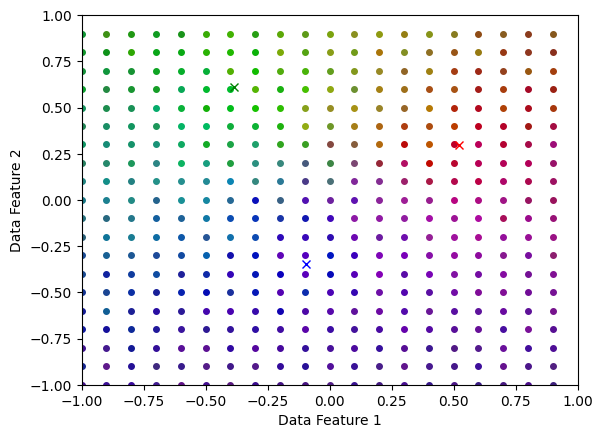

In [11]:
point_list = []
fig, ax = plt.subplots()
ax.set(xlabel='Data Feature 1', ylabel='Data Feature 2')

heatmap_size = 10

for i in range(-heatmap_size,heatmap_size):
    for j in range(-heatmap_size,heatmap_size):
        qc = create_circuit(i/heatmap_size, j/heatmap_size)
        simulator = QasmSimulator()
        compiled_circuit = transpile(qc, simulator)
        # Execute the circuit on the qasm simulator
        job = simulator.run(compiled_circuit, shots=1000)
        # Grab results from the job
        result = job.result()
        counts = result.get_counts(compiled_circuit)
        color = get_max_class(counts)
        plt.plot(i/heatmap_size, j/heatmap_size, "o",markersize=4, color=color)

# Plotting the centroids
plt.plot(xgc, ygc, 'gx')
plt.plot(xbc, ybc, 'bx')
plt.plot(xkc, ykc, 'rx')

# Setting the axis ranges
plt.axis([-1, 1, -1, 1])

plt.show()

In [12]:
def get_sphere_projection_of_2D_data(x, y, labels):
    radius = 1
    data = []
    for i in range(len(x)):
        rad_x = radius * np.cos(y[i]) * np.cos(x[i])
        rad_y = radius * np.cos(y[i]) * np.sin(x[i])
        rad_z = radius * np.sin(y[i])
        rad_label = labels[i]
        rad_label = (rad_label[0]*255, rad_label[1]*255, rad_label[2]*255)
        rad_label = np.round_(rad_label)

        data.append([rad_x, rad_y, rad_z, rad_label])

    dataset = pd.DataFrame(data, columns=['X', 'Y','Z', 'Color'])
    return dataset

def get_heatmap_sphere_projection_figure(dataset):
    print(dataset)
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)
    sphere_data = [
    Surface(
        x=x,
        y=y,
        z=z,
        surfacecolor=x**2 + y**2 + z**2,
        colorscale='Blackbody',
        showscale=False
    ),
    ]
    sphere_fig = go.Figure(data=sphere_data)
    points_fig = px.scatter_3d(dataset, x='X', y='Y', z='Z',
                color='Color', color_discrete_map="identity")
    return go.Figure(data = sphere_fig.data + points_fig.data)

<ipython-input-9-38900eb84942>:15: DeprecationWarning:

The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).



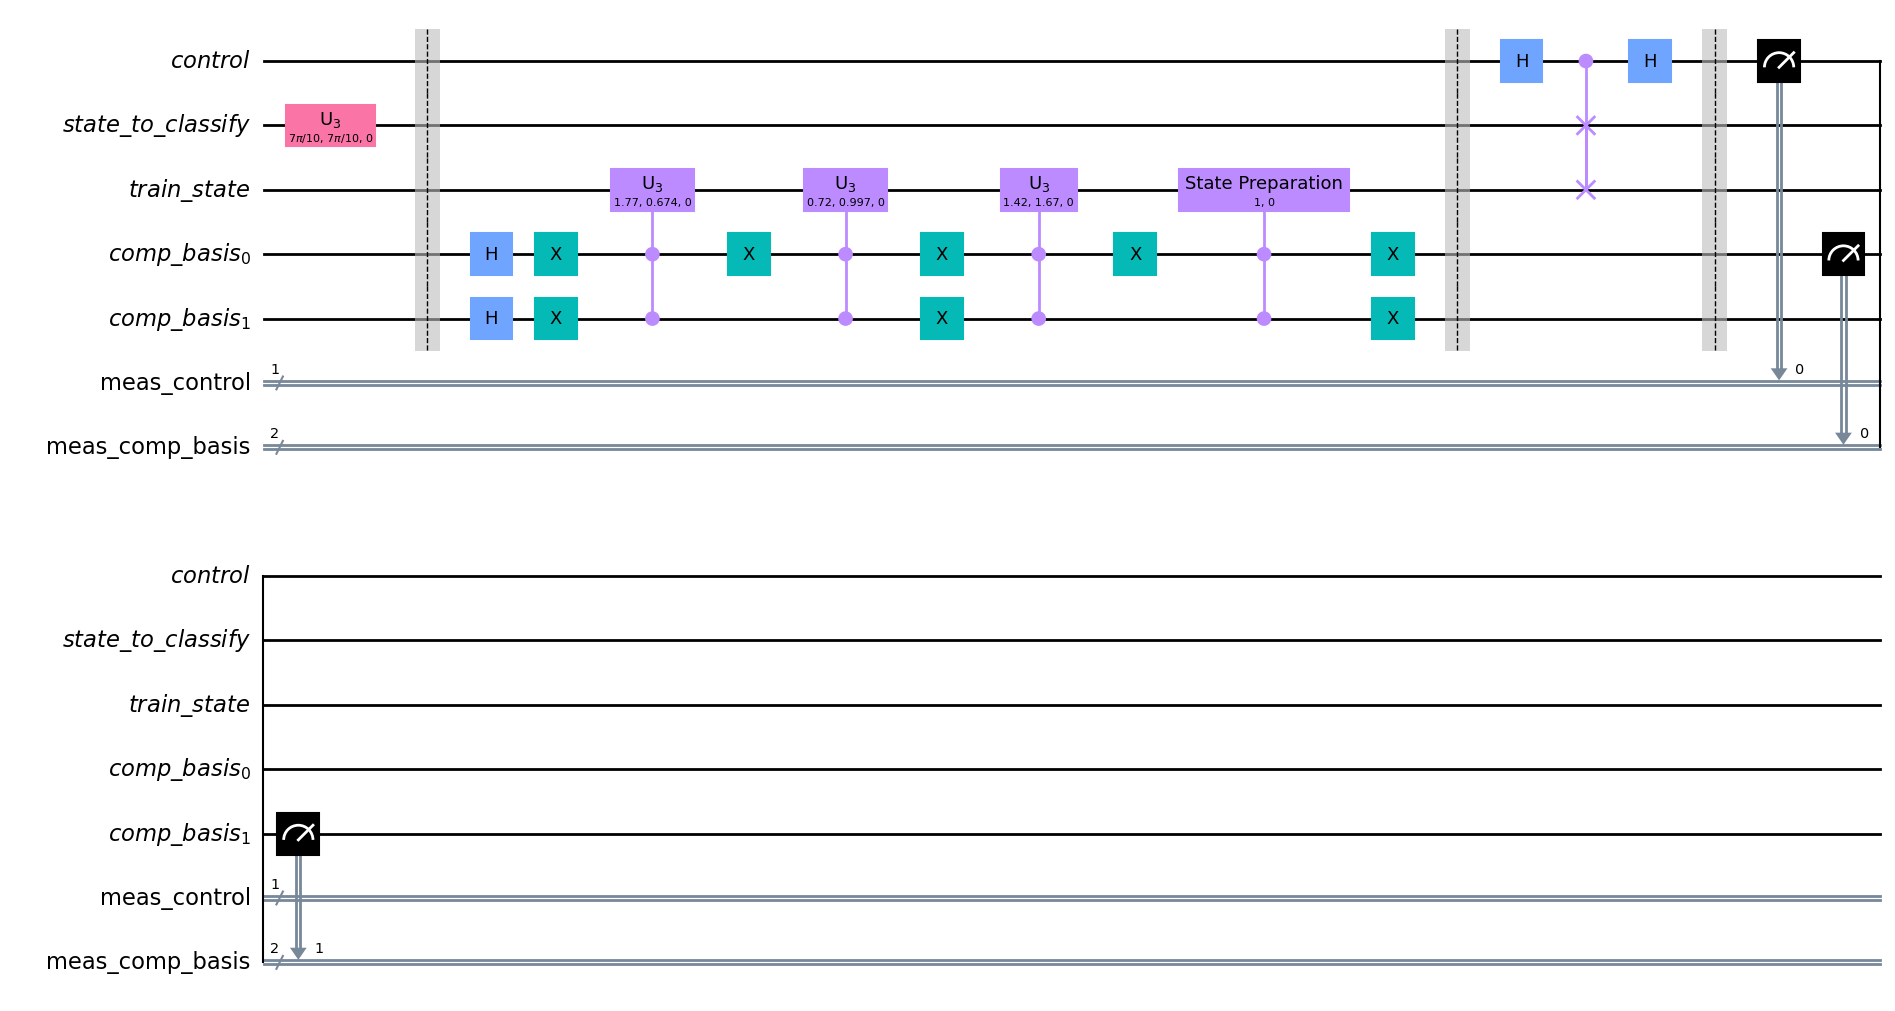

In [13]:
qc_main = create_circuit(x_p, y_p)

qc_main.draw('mpl')

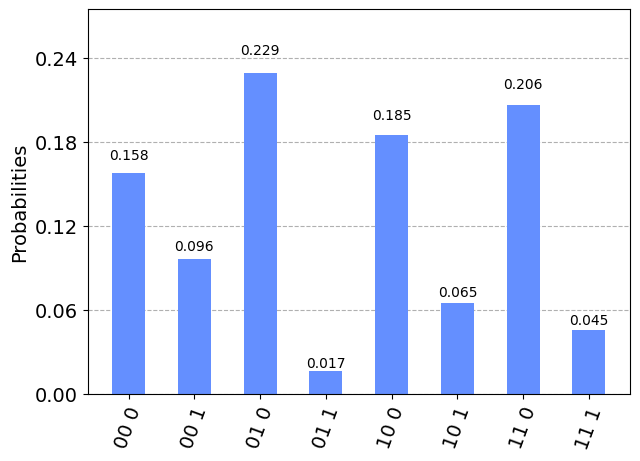

In [14]:
simulator = QasmSimulator()

compiled_circuit = transpile(qc, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=10000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)

plot_histogram(counts)

## Fidelity

To properly interpret the data, it's necessary to extract fidelity (a measure of similarity between two qubits). To do this, we take the "counts" of the values and use a formula to convert the results.

In [19]:
prob_vert = counts['11 0']/(counts['11 0'] + counts['11 1'])
prob_bleu = counts['10 0']/(counts['10 0'] + counts['10 1'])
prob_noir = counts['01 0']/(counts['01 0'] + counts['01 1'])

fid_vert = math.sqrt(2 * prob_vert - 1)
fid_bleu = math.sqrt(2 * prob_bleu - 1)
fid_noir = math.sqrt(2 * prob_noir - 1)

fidelities = [fid_vert, fid_bleu, fid_noir]
classes = ["Green", "Blue", "Black"]

print("Green fidelity : "+str(fid_vert))
print("Blue fidelity : "+str(fid_bleu))
print("Black fidelity : "+str(fid_noir))

index = fidelities.index(max(fidelities))
print("Resulting class : "+str(classes[index])+" with fidelity of "+str(fidelities[index]))

Green fidelity : 0.7990359706047171
Blue fidelity : 0.6936532069063645
Black fidelity : 0.9303363221822731
Resulting class : Black with fidelity of 0.9303363221822731


# Conclusion and Analysis

The k-means algorithm works well for assessing distances between the desired point and the centroids. However, we noticed that some predictions did not match what we expected with a classical algorithm. This is related to the fact that the encoding of values is done on a sphere. Thus, some values that should be far apart are close. To address this issue, we compressed the data so that the boundary values of each class are far from each other.

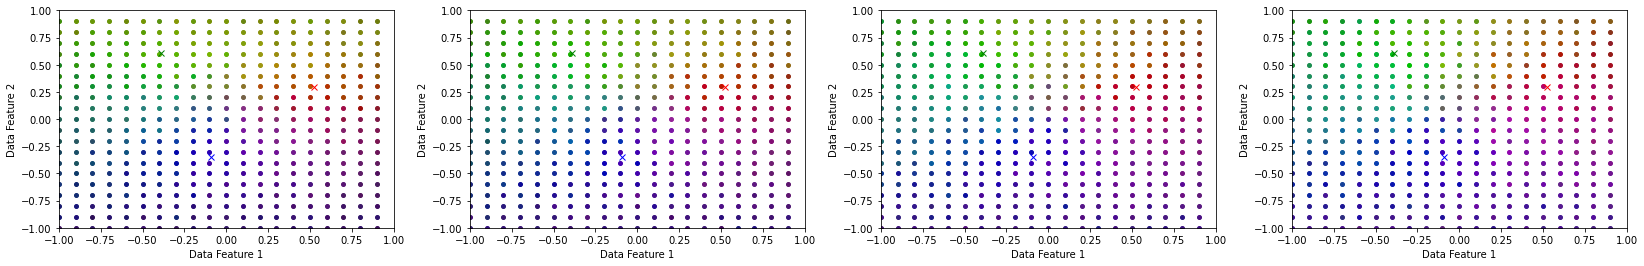

In [16]:
from IPython.display import Image
Image(filename='./MergedImages.png')

In the picture above, we have placed four "heat-maps", each representing the prediction made by the Quantum K-Means. The result on the far right corresponds to a border value of 0%, and each subsequent result has an increase of 10%. We can see that the charts with 20% and 30% have better results for predicting close to the borders of the array.

## Bibliography

#### K-MEAN
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://towardsdatascience.com/quantum-machine-learning-distance-estimation-for-k-means-clustering-26bccfbfcc76

#### QRAM

https://quantumcomputinguk.org/tutorials/implementing-qram-in-qiskit-with-code